In [1]:
from DataFetcher import DataFetcher
from USTs import USTs
from Curves import ParCurves, calibrate_mles
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import plotly.graph_objects as go

In [2]:
auctions = DataFetcher().fetch_auction_data()
prices = DataFetcher().fetch_historical_UST_data(date=datetime.datetime(year=2025, month=6, day=26))

In [3]:
usts = USTs(auction_data=auctions,price_data=prices)
ust_set = usts.get_current_UST_set(settlement_date=datetime.datetime(2025, 6, 27),
                                   get_ytms=True,
                                   include_FRNs=False,
                                   include_TIPS=False,
                                   include_outstanding=False)
ust_set

Merged auction and price data successfully
No missing or excess data
All CUSIPs are identical between DataFrames


,Security type,Rate,Maturity date,End of day,Security term,Issue date,Years to maturity,UST label,EOD YTM,Duration,Rank
Cusip,,,,,,,,,,,
912828XZ8,Note,2.750,2025-06-30,99.968750,7-Year,2018-07-02,0.010959,2.750% Jun-25,6.559941,0.007980,84
91282CHL8,Note,4.625,2025-06-30,99.968750,2-Year,2023-06-30,0.010959,4.625% Jun-25,8.400867,0.007910,24
912828ZW3,Note,0.250,2025-06-30,99.968750,5-Year,2020-06-30,0.010959,0.250% Jun-25,4.078317,0.008077,58
912797PU5,Bill,0.000,2025-07-01,99.954778,17-Week,2025-03-04,0.013699,0.000% Jul-25,4.128374,0.016467,17
912797NX1,Bill,0.000,2025-07-03,99.932333,26-Week,2025-01-02,0.019178,0.000% Jul-25,4.119197,0.016240,19
...,...,...,...,...,...,...,...,...,...,...,...
912810UA4,Bond,4.625,2054-05-15,96.687500,30-Year,2024-05-15,28.904110,4.625% May-54,4.840632,15.526043,5
912810UC0,Bond,4.250,2054-08-15,90.906250,30-Year,2024-08-15,29.156164,4.250% Aug-54,4.833356,15.708498,4
912810UE6,Bond,4.500,2054-11-15,94.875000,30-Year,2024-11-15,29.408219,4.500% Nov-54,4.829236,15.752849,3


In [4]:
filtered_set = ust_set[(ust_set['Years to maturity'] > 90/365) & (ust_set['Security type'] != 'Bill') & (ust_set['Rank'] > 2)]

curve_builder = ParCurves(filtered_set)
spline_x, spline_y = curve_builder.univariate_spline(smoothness=0.2, return_data=True)

bspline_x, bspline_y = curve_builder.Bspline_with_knots(knots=[0.5, 1, 2, 3, 5, 7, 8, 9, 10, 15, 20, 25])

mles_curve, _ = calibrate_mles(maturities=filtered_set['Years to maturity'].to_numpy(), # Merrill Lynch Exponential Spline (parametric model)
               yields=filtered_set['EOD YTM'].to_numpy(),
               N=9,
               overnight_rate=4.33)
mles_x = np.arange(0.25, 30, 0.05)
mles_y = mles_curve.theoretical_yields(maturities=mles_x)

fig = go.Figure()
hovertemplate = (
    "<b>CUSIP:</b> %{customdata[0]}<br>"+
    "<b>YTM:</b> %{y:.3%}<br>"+
    "<b>Coupon</b> %{customdata[2]}<br>"+
    "<b>Price:</b> %{customdata[4]:.4f}<br>"+
    "<b>Duration:</b> %{customdata[10]:.2f}<br>"+
    "<b>Maturity date:</b> %{customdata[3]|%Y-%m-%d}<br>"+
    "<b>Issue date:</b> %{customdata[6]|%Y-%m-%d}<br>"
)

years = ['2', '3', '5', '7', '10', '20', '30']
terms = [tenor + '-Year' for tenor in years] # Ordered list
for tenor in terms:
    subset = ust_set[(ust_set['Security term'] == tenor) & (ust_set['Years to maturity'] > 90/365)].reset_index(drop=False)
    custom_data = subset.to_numpy()
    fig.add_trace(go.Scatter(
        x=subset['Years to maturity'],
        y=subset['EOD YTM']/100,
        mode='markers',
        name=tenor,
        hovertemplate=hovertemplate,
        customdata=custom_data,
        text=subset['EOD YTM'],
        marker=dict(
            size=8
        )
    ))
fig.add_trace(go.Scatter(
    x=spline_x,
    y=spline_y/100,
    mode='lines',
    name='Smoothed cubic spline'
))
fig.add_trace(go.Scatter(
    x=mles_x,
    y=mles_y/100,
    mode='lines',
    name='Merrill Lynch Exponential Spline',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=bspline_x,
    y=bspline_y/100,
    mode='lines',
    name='Cubic B-spline with knots',
    line=dict(width=3)
))
fig.update_layout(
    title='US Treasury Yield Curve',
    width=1400,
    height=600,
    margin=dict(l=20, r=20, t=50, b=20),
    xaxis_title='Years to maturity',
    yaxis_title='End-of-Day Yield to Maturity (YTM)',
    yaxis_tickformat='.2%',
    legend_title_text='Security Tenors',
    template='plotly_dark'
)
fig.show()


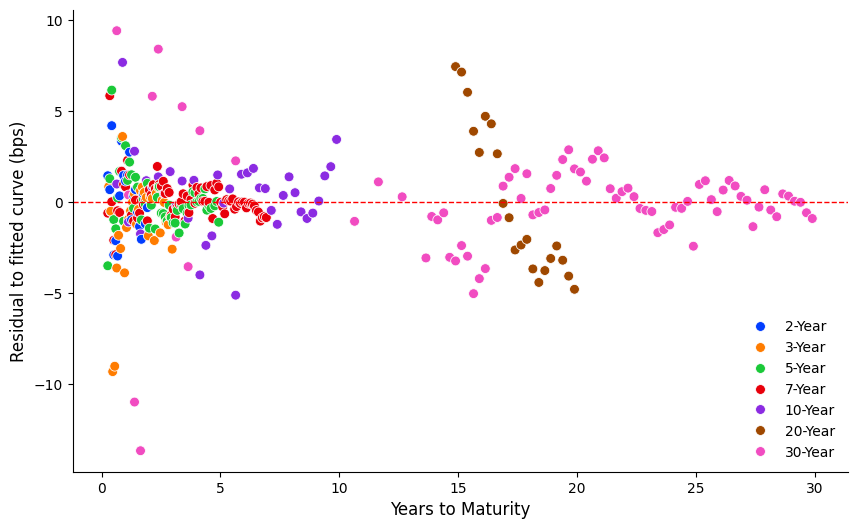

In [5]:
bond_df_with_residuals = usts.get_residuals(curve=(bspline_x, bspline_y), return_full_df=True, plot_residuals=True)

In [6]:
fig = go.Figure()
data = bond_df_with_residuals[(bond_df_with_residuals['Duration'] > 9) & (bond_df_with_residuals['Duration'] < 14)]
tenors = ['20-Year', '30-Year']

for tenor in tenors:
    plot_data = data[data['Security term'] == tenor]
    fig.add_trace(go.Scatter(
        x=plot_data['Duration'],
        y=plot_data['EOD YTM']/100,
        mode='markers+text',
        marker=dict(size=10),
        customdata=plot_data.reset_index().values,
        hovertemplate=hovertemplate,
        name=tenor,
        text=plot_data['Maturity date'].dt.strftime('%b-%y'),
        textposition='top center',
        textfont=dict(size=10)
    ))

fig.update_layout(
    title='Selected Treasury YTMs and Durations',
    width=1000,
    height=600,
    margin=dict(l=20, r=20, t=50, b=20),
    xaxis_title='Duration (Years)',
    yaxis_title='End-of-Day Yield to Maturity (YTM)',
    yaxis_tickformat='.2%',
    legend_title_text='Security Tenors',
    template='plotly_dark'
)

In [7]:
full_df, interpolated_df = usts.get_initial_screening_set(curve_builder.bspline_model)
full_df

,Security term long,Years to maturity long,UST label long,EOD YTM long,Duration long,Security term short,Years to maturity short,UST label short,EOD YTM short,Duration short,Implied tenor long,Implied tenor short,Curve exposure,Par curve slope,Spread to par curve
44,30-Year,19.150685,3.125% Aug-44,4.862613,13.322299,20-Year,15.400000,1.375% Nov-40,4.757422,13.072926,22.0,21.5,21.5s22.0s flattener,0.010948,0.094243
42,30-Year,17.895890,2.875% May-43,4.833758,13.073680,20-Year,14.895890,1.125% May-40,4.729779,12.988983,21.5,21.0,21.0s21.5s flattener,0.011543,0.092436
14,30-Year,15.652055,4.750% Feb-41,4.665072,10.796430,30-Year,13.649315,3.500% Feb-39,4.496092,10.402733,15.5,14.5,14.5s15.5s flattener,0.086886,0.082094
12,30-Year,14.895890,4.375% May-40,4.623080,10.722116,30-Year,13.649315,3.500% Feb-39,4.496092,10.402733,15.0,14.5,14.5s15.0s flattener,0.046950,0.080038
39,30-Year,19.150685,3.125% Aug-44,4.862613,13.322299,20-Year,15.652055,1.875% Feb-41,4.754230,12.659995,22.0,20.0,20.0s22.0s flattener,0.045280,0.063103
40,30-Year,19.402740,3.000% Nov-44,4.876460,13.659248,20-Year,15.652055,1.875% Feb-41,4.754230,12.659995,23.0,20.0,20.0s23.0s flattener,0.063306,0.058924
38,30-Year,19.150685,3.125% Aug-44,4.862613,13.322299,20-Year,15.895890,2.250% May-41,4.758650,12.547058,22.0,20.0,20.0s22.0s flattener,0.045280,0.058683
16,30-Year,15.400000,4.250% Nov-40,4.667449,11.019695,30-Year,13.649315,3.500% Feb-39,4.496092,10.402733,16.0,14.5,14.5s16.0s flattener,0.120148,0.051209
17,30-Year,15.895890,4.375% May-41,4.689378,11.194750,30-Year,13.649315,3.500% Feb-39,4.496092,10.402733,16.5,14.5,14.5s16.5s flattener,0.147584,0.045702
32,30-Year,18.147945,3.625% Aug-43,4.818033,12.511156,30-Year,16.147945,3.750% Aug-41,4.709989,11.532296,19.5,17.0,17.0s19.5s flattener,0.067375,0.040669


In [8]:
curve_builder.bspline_model(28)

array(4.85921347)

In [9]:
pd.DataFrame(columns=['Duration exposure', 'Current spread', 'Target spread', 'Long bond', 'Tenor', 'YTM', 'Bspline residual', 'Short bond', 'Tenor', 'YTM', 'Bspline residual'])

,Duration exposure,Current spread,Target spread,Long bond,Tenor,YTM,Bspline residual,Short bond,Tenor,YTM,Bspline residual


In [10]:
yields, prices = usts.get_cusip_timeseries(CUSIPs=['912810SR0', '912810TF5'],
                          start_date=datetime.date(2025, 6, 10),
                          end_date=datetime.date(2025, 6, 26))
yields

,912810SR0,912810TF5,Spread
Date,,,
2025-06-10,4.885072,4.947760,0.062688
2025-06-11,4.834285,4.903899,0.069614
2025-06-12,4.756544,4.830092,0.073548
2025-06-13,4.836695,4.908707,0.072012
2025-06-16,4.888736,4.963595,0.074859
2025-06-17,4.810358,4.882318,0.071960
2025-06-18,4.819417,4.886403,0.066986
2025-06-20,4.817287,4.887462,0.070175
2025-06-23,4.782582,4.854056,0.071474
